In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import lsst.daf.persistence        as dafPersist

import lsst.afw.display            as afwDisplay
import lsst.afw.table              as afwTable

Load the high-level "tasks" that process the pixels

In [3]:
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate         import CalibrateTask
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.deblender               import SourceDeblendTask
from lsst.meas.base                    import SingleFrameMeasurementTask

import lsst.meas.extensions.photometryKron

Setup the displays (by default an interface to ds9)

In [4]:
disp  = afwDisplay.Display(1)
disp2 = afwDisplay.Display(2)

## Create the tasks

In [5]:
schema = afwTable.SourceTable.makeMinimalSchema()
algMetadata = dafBase.PropertyList()

config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask =         CharacterizeImageTask(None, config=config)

sourceDetectionTask =   SourceDetectionTask(schema=schema)

sourceDeblendTask =     SourceDeblendTask(schema=schema)

config = SingleFrameMeasurementTask.ConfigClass()
#config.doApplyApCorr = 'yes'
config.slots.apFlux = 'base_CircularApertureFlux_12_0'
config.plugins.names.add("ext_photometryKron_KronFlux")
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config,
                                                   algMetadata=algMetadata)

## Time to process some data

#### Read the input data

In [6]:
butler = dafPersist.Butler("/Volumes/RHLData/hsc-v13_0")

In [7]:
if False:
    dataId = dict(tract=9348, patch='7,6', filter='HSC-I')
    exposure = butler.get('deepCoadd_calexp',dataId)
else:
    dataId = dict(visit=29352, ccd=50)
    exposure = butler.get('calexp', dataId)

#### Create the output table

In [8]:
tab = afwTable.SourceTable.make(schema)

#### Process the pixels

##### Characterise the exposure (e.g. estimate the PSF)

In [9]:
result = charImageTask.characterize(exposure)

psfCellSet = result.psfCellSet     # we'll look at this data structure later

##### Detect objects (`sources')

In [10]:
result = sourceDetectionTask.run(tab, exposure)
sources = result.sources

##### Deblend overlapping objects

In [11]:
sourceDeblendTask.run(exposure, sources)

##### Measure the objects' properties

In [12]:
sourceMeasurementTask.run(exposure, sources)

#### Write the results to a FITS file (if desired)

In [13]:
if False:
    sources.writeFits("outputTable.fits")
    exposure.writeFits("example1-out.fits")

### OK, we've finished the image processing.

In [14]:
import lsst.afw.image.utils as afwImageUtils

Define a boolean array that tells us which objects are 'good'; in this case:
 - No saturated pixels near their centres
 - terminal objects that haven't been further deblended

In [15]:
sources = sources.copy(True)
good = np.logical_and.reduce([sources.get('base_PixelFlags_flag_saturatedCenter') == 0,
                              sources.get("deblend_nChild") == 0,
                              ])

#### Look at how well the aperture and Kron photometry agrees with the PSF measurements

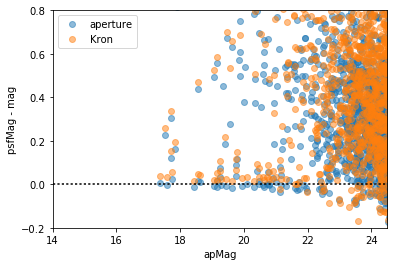

In [16]:
with afwImageUtils.CalibNoThrow():
    apMag = exposure.getCalib().getMagnitude(sources.getApFlux())
    kronMag = exposure.getCalib().getMagnitude(sources["ext_photometryKron_KronFlux_flux"])
    psfMag = exposure.getCalib().getMagnitude(sources.getPsfFlux())

for mag, name in [
                    (apMag, "aperture"),
                    (kronMag, "Kron")
                 ]:
    plt.plot(apMag[good], (psfMag - mag)[good], 'o', alpha=0.5, label=name)

plt.legend(loc='best')
plt.axhline(0.0, ls=':', color='black')
plt.xlim(14, 24.5)
plt.ylim(-0.2, 0.8)

plt.xlabel("apMag")
plt.ylabel("psfMag - mag")

plt.show()

In [17]:
if True:
    disp2.mtv(exposure)
else:
    disp2.erase()

In [18]:
Kron_nRadiusForFlux = algMetadata.get("ext_photometryKron_KronFlux_nRadiusForFlux")

with disp2.Buffering():
    for s in sources[good]:
        shape = s.getShape().clone()
        rDet = shape.getDeterminantRadius()

        shape.scale(s["ext_photometryKron_KronFlux_radius"]/rDet)
        disp2.dot(shape, *s.getCentroid(), ctype=afwDisplay.RED)

        shape.scale(Kron_nRadiusForFlux)
        disp2.dot(shape, *s.getCentroid(), ctype=afwDisplay.CYAN)